In [1]:
import torch, gc, os
import pandas as pd
import numpy as np

import utils.print as print_f

from utils.coco_eval import get_eval_params_dict
from utils.engine import xami_train_one_epoch, xami_evaluate
from utils.plot import plot_loss, plot_train_val_evaluators
from utils.save import get_train_data

from models.load import ModelSetup, create_model_from_setup
from utils.save import check_best, end_train, TrainingInfo
from utils.data import get_datasets, get_dataloaders
from IPython.display import clear_output
from utils.coco_eval import get_ar_ap


## Suppress the assignement warning from pandas.r
pd.options.mode.chained_assignment = None  # default='warn'

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
gc.collect()
# torch.cuda.memory_summary(device=None, abbreviated=False)

use_gpu = torch.cuda.is_available()
device = 'cuda' if use_gpu else 'cpu'
print(f"This notebook will running on device: [{device.upper()}]")

if use_gpu:
    torch.cuda.empty_cache()

This notebook will running on device: [CUDA]


In [3]:
XAMI_MIMIC_PATH = "D:\XAMI-MIMIC"

use_iobb = True
io_type_str = "IoBB" if use_iobb else "IoU"

## train for 20 epoch first.
all_model_setups = [
    # ModelSetup(
    #     name="original",
    #     use_clinical=False,
    #     use_custom_model=False,
    #     use_early_stop_model=True,
    # ),
    # ModelSetup(
    #     name="custom_without_clinical",
    #     use_clinical=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    # ),
    ModelSetup(
        name="custom_with_clinical",
        use_clinical=True,
        use_custom_model=True,
        use_early_stop_model=False,
    ),
]

In [4]:
labels_cols = [
    "Enlarged cardiac silhouette",
    "Atelectasis",
    "Pleural abnormality",
    "Consolidation",
    "Pulmonary edema",
    #  'Groundglass opacity', # 6th disease.
]

iou_thrs = np.array(
        [
            0.00,
            0.05,
            0.1,
            0.15,
            0.2,
            0.25,
            0.3,
            0.35,
            0.4,
            0.45,
            0.5,
            0.55,
            0.6,
            0.65,
            0.7,
            0.75,
            0.8,
            0.85,
            0.9,
            0.95,
            1.0,
        ]
    )

In [5]:
num_epochs = 200
train_infos = []

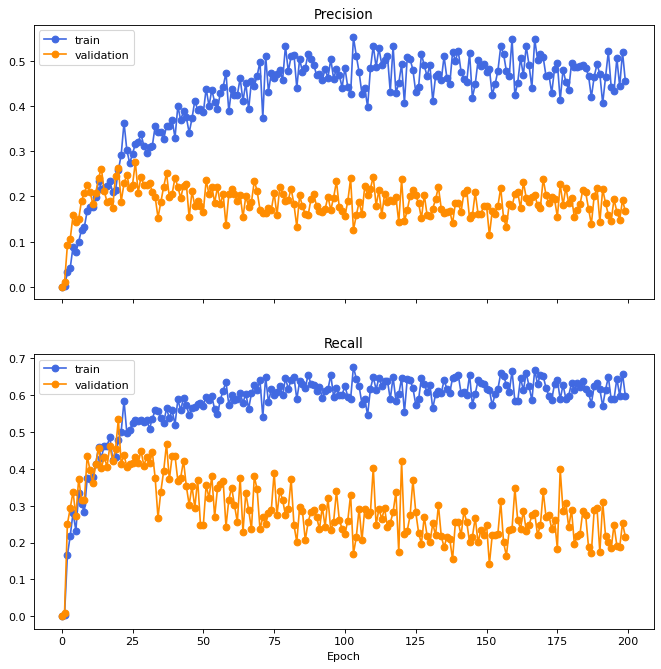

NameError: name 'val_ar' is not defined

In [6]:
for model_setup in all_model_setups:
    train_info = TrainingInfo(model_setup)

    ################ Datasets ################
    dataset_params_dict = {
        "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
        "with_clinical": model_setup.use_clinical,
        "dataset_mode": "unified",
        "bbox_to_mask": True,
        "labels_cols": labels_cols,
    }

    detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
        dataset_params_dict=dataset_params_dict
    )

    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
        train_dataset, val_dataset, test_dataset, batch_size=4
    )

    model = create_model_from_setup(labels_cols, model_setup)
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    print(f"Model size: {sum([param.nelement()  for param in model.parameters()]):,}")

    optimizer = torch.optim.SGD(
        params,
        lr=0.005,
        momentum=0.9,
        weight_decay=0.0005,
    )

    lr_scheduler = None

    eval_params_dict = get_eval_params_dict(
        detect_eval_dataset, iou_thrs=iou_thrs, use_iobb=use_iobb,
    )

    ## Start the training from here.
    for e in range(num_epochs):

        print_f.print_title(f"Training model: [{model_setup.name}]")

        train_info.epoch = e + 1

        ###### Perform training and show the training result here ######
        model.train()
        train_loger = xami_train_one_epoch(
            model, optimizer, train_dataloader, device, train_info.epoch, print_freq=10,
        )
        train_info.train_data.append(get_train_data(train_loger))
        plot_loss(train_info.train_data)
        ################################################################

        ### update the learning rate
        if not  lr_scheduler is None:
            lr_scheduler.step()

        ####### Put the model into evaluation mode, start evaluating the current model #######
        model.eval()

        ### evaluate on the validation dataset
        train_evaluator = xami_evaluate(
            model, train_dataloader, device=device, params_dict=eval_params_dict
        )
        train_info.train_evaluators.append(train_evaluator)

        val_evaluator = xami_evaluate(
            model, val_dataloader, device=device, params_dict=eval_params_dict
        )

        train_info.val_evaluators.append(val_evaluator)

        ## Clean everything before we show the evaluating result in this stage, so we can inspect the training progress.
        clear_output()

        plot_train_val_evaluators(
            train_info.train_evaluators,
            train_info.val_evaluators,
            areaRng="all",
            iouThr=0.5,
            maxDets=10,
        )

        #######################################################################################

        val_ar, val_ap, train_info = check_best(
            train_info, eval_params_dict, model, test_dataloader, device
        )

    val_ar, val_ap = get_ar_ap(train_info.val_evaluators[-1])

    train_info = end_train(
        train_info, model, eval_params_dict, val_ar, val_ap, test_dataloader, device
    )

    train_infos.append(train_info)


In [8]:
for idx, train_info in enumerate(train_infos):
    print("="*40 + f"For Training [{train_info.model_setup.name}]" + "="*40)
    print(train_info.model_setup)
    print("="*40)  
    print(f"Best AR validation model has been saved to: [{train_info.best_ar_val_model_path}]")
    print(f"Best AP validation model has been saved to: [{train_info.best_ap_val_model_path}]")
    print(f"The final model has been saved to: [{train_info.final_model_path}]")


========================================For Training [custom_with_clinical]========================================
ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=False, name='custom_with_clinical', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None)
Best AR validation model has been saved to: [None]
Best AP validation model has been saved to: [None]
The final model has been saved to: [val_ar_0_2161_ap_0_1670_test_ar_0_2727_ap_0_1556_epoch200_WithClincal_03-31-2022 17-21-23_custom_with_clinical]


## Model Paths 

In [ ]:
model.dropout_rate

0.0

In [ ]:
### Full training

# ========================================For Training [original]========================================
# ModelSetup(use_clinical=False, use_custom_model=False, use_early_stop_model=True, name='original', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None)
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5230_ap_0_2576_test_ar_0_5678_ap_0_2546_epoch28_WithoutClincal_03-28-2022 06-56-13_original] *
# Best AP validation model has been saved to: [val_ar_0_4828_ap_0_2977_test_ar_0_5052_ap_0_2331_epoch20_WithoutClincal_03-28-2022 06-34-49_original]
# The final model has been saved to: [val_ar_0_4463_ap_0_2006_test_ar_0_4904_ap_0_2154_epoch50_WithoutClincal_03-28-2022 07-51-38_original]


# ========================================For Training [custom_without_clinical]========================================
# ModelSetup(use_clinical=False, use_custom_model=True, use_early_stop_model=True, name='custom_without_clinical', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None)
# ========================================
# Best AR validation model has been saved to: [val_ar_0_4941_ap_0_2401_test_ar_0_5191_ap_0_2368_epoch11_WithoutClincal_03-28-2022 08-19-58_custom_without_clinical]
# Best AP validation model has been saved to: [val_ar_0_4575_ap_0_2689_test_ar_0_4953_ap_0_2561_epoch40_WithoutClincal_03-28-2022 09-15-40_custom_without_clinical] *
# The final model has been saved to: [val_ar_0_3348_ap_0_2367_test_ar_0_3721_ap_0_1814_epoch50_WithoutClincal_03-28-2022 09-34-36_custom_without_clinical]

### Dropout = (0.0)
# ========================================For Training [custom_with_clinical]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None)
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5363_ap_0_2963_test_ar_0_5893_ap_0_2305_epoch36_WithClincal_03-28-2022 20-06-43_custom_with_clinical]*
# Best AP validation model has been saved to: [val_ar_0_5363_ap_0_2963_test_ar_0_5893_ap_0_2305_epoch36_WithClincal_03-28-2022 20-06-44_custom_with_clinical]
# The final model has been saved to: [val_ar_0_3798_ap_0_2078_test_ar_0_5041_ap_0_2052_epoch50_WithClincal_03-28-2022 20-36-05_custom_with_clinical]


### Dropout = (0.2)
# ========================================For Training [custom_with_clinical]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None)
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5126_ap_0_2498_test_ar_0_5607_ap_0_2538_epoch18_WithClincal_03-28-2022 10-18-55_custom_with_clinical]*
# Best AP validation model has been saved to: [val_ar_0_5090_ap_0_2753_test_ar_0_5324_ap_0_2337_epoch32_WithClincal_03-28-2022 10-47-07_custom_with_clinical]
# The final model has been saved to: [val_ar_0_3097_ap_0_2025_test_ar_0_3521_ap_0_1591_epoch50_WithClincal_03-28-2022 11-22-58_custom_with_clinical]

### Dropout = (0.3)
# ========================================For Training [custom_with_clinical]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None)
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5512_ap_0_2769_test_ar_0_4896_ap_0_1875_epoch48_WithClincal_03-28-2022 16-01-09_custom_with_clinical]
# Best AP validation model has been saved to: [val_ar_0_4631_ap_0_2860_test_ar_0_4462_ap_0_2249_epoch46_WithClincal_03-28-2022 15-56-11_custom_with_clinical]
# The final model has been saved to: [val_ar_0_3993_ap_0_2326_test_ar_0_4957_ap_0_2390_epoch50_WithClincal_03-28-2022 16-06-00_custom_with_clinical]*


### Dropout = (0.5)
# ========================================For Training [custom_with_clinical]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None)
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5887_ap_0_2834_test_ar_0_5532_ap_0_1683_epoch34_WithClincal_03-28-2022 17-38-54_custom_with_clinical]
# Best AP validation model has been saved to: [val_ar_0_4955_ap_0_2942_test_ar_0_5449_ap_0_2566_epoch28_WithClincal_03-28-2022 17-25-34_custom_with_clinical]*
# The final model has been saved to: [val_ar_0_4053_ap_0_2322_test_ar_0_4286_ap_0_2031_epoch50_WithClincal_03-28-2022 18-12-35_custom_with_clinical]


# We need a enum function to load the model.

In [ ]:
# 50 epoch
# val_ar_0_2370_ap_0_1530_test_ar_0_2396_ap_0_1236_epoch50_WithoutClincal_03-27-2022 02-41-12 (original)
# val_ar_0_2658_ap_0_1993_test_ar_0_2717_ap_0_1816_epoch50_WithoutClincal_03-27-2022 04-56-32(custom without clinical)
# val_ar_0_3839_ap_0_2107_test_ar_0_5359_ap_0_2286_epoch50_WithClincal_03-27-2022 06-59-57 (custom with clinical)

# Single 100 epoch
# val_ar_0_4986_ap_0_2911_test_ar_0_5360_ap_0_2273_epoch35_WithClincal_03-27-2022 16-00-27 (best)
# val_ar_0_1551_ap_0_1462_test_ar_0_2225_ap_0_1449_epoch100_WithClincal_03-27-2022 18-23-42(final)
